In [ ]:
!git clone https://github.com/j-wilson/GPflowSampling.git
!pip install gpflow

!python GPflowSampling/setup.py build
!python GPflowSampling/setup.py install

import sys
sys.path.insert(0, "GPflowSampling")

Cloning into 'GPflowSampling'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 185 (delta 69), reused 162 (delta 55), pack-reused 0
Receiving objects: 100% (185/185), 3.83 MiB | 9.57 MiB/s, done.
Resolving deltas: 100% (69/69), done.
     |████████████████████████████████| 276kB 7.5MB/s 
running build
running install
running bdist_egg
running egg_info
creating gpflow_sampling.egg-info
writing gpflow_sampling.egg-info/PKG-INFO
writing dependency_links to gpflow_sampling.egg-info/dependency_links.txt
writing requirements to gpflow_sampling.egg-info/requires.txt
writing top-level names to gpflow_sampling.egg-info/top_level.txt
writing manifest file 'gpflow_sampling.egg-info/SOURCES.txt'
reading manifest file 'gpflow_sampling.egg-info/SOURCES.txt'
writing manifest file 'gpflow_sampling.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

c

In [ ]:
import gpflow
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm.notebook import tqdm
from tensorflow.python import linalg as tfla
import tensorflow_probability as tfp 
from gpflow.config import default_jitter, default_float as floatx
from gpflow_sampling.models import PathwiseSVGP
from gpflow.utilities import print_summary, set_trainable, to_default_float
import itertools
from sklearn.linear_model import LogisticRegression
from google.colab import drive
import time
from gpflow.ci_utils import ci_niter
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import matplotlib.pyplot as plt
import gc
%matplotlib inline
plt.rc('figure', dpi=256)
plt.rc('font', family='serif', size=12)
# plt.rc('text', usetex=True)
# plt.rc('text.latex', preamble=r'''
#        \usepackage{amsmath,amsfonts}
#        \renewcommand{\v}[1]{\boldsymbol{#1}}''')

In [ ]:
tf.random.set_seed(1)

In [ ]:
class CustomPathwiseSVGP(PathwiseSVGP):
    def elbo(self, data: tuple, num_samples: int = 16, num_bases: int = 1024) -> tf.Tensor:
        """
        Estimate the evidence lower bound on the log marginal likelihood of the model 
        by using decoupled sampling to construct a Monte Carlo integral.
        """
        X, y = data
        with self.temporary_paths(num_samples=num_samples, num_bases=num_bases):
            f = self.predict_f_samples(X)
            
        if hasattr(self.likelihood, 'invlink'):
            f = self.likelihood.invlink(f)
        
        kl = self.prior_kl()
        monte_carlo = tf.reduce_mean(self.likelihood.log_prob(f, y), axis=0)
        if self.num_data is not None:
            num_data = tf.cast(self.num_data, kl.dtype)
            minibatch_size = tf.cast(tf.shape(X)[0], kl.dtype)
            scale = num_data / minibatch_size
        else:
            scale = tf.cast(1.0, kl.dtype)

        return tf.reduce_sum(monte_carlo) * scale - kl

In [ ]:
def read_data(filename):
    data = pd.read_excel(filename, header=1)
    data = data.drop(columns=['ID'])
    columns_for_normalizing = data.columns[10:-1]
    columns_for_normalizing = columns_for_normalizing.append(pd.Index(  ['LIMIT_BAL', 'AGE'] ))
    data[columns_for_normalizing] = StandardScaler().fit_transform(data[columns_for_normalizing])
    X, y = data.drop(columns=[data.columns[-1]]).values, data.iloc[:, -1].values
    X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size = 0.2)
    return tf.convert_to_tensor(X_train),\
            tf.convert_to_tensor(X_test),\
            tf.convert_to_tensor(y_train[:, None]),\
            tf.convert_to_tensor(y_test[:, None])

filepath = '/content/drive/My Drive/science/'
X_train, X_test, y_train, y_test = read_data(filepath + "default of credit card clients.xls")

In [ ]:
#Answers
def get_exact_function(X):
    return tfp.distributions.Bernoulli(probs = tf.math.sigmoid(tf.math.sin(X)**2 * X)).sample()


def calculate_quality(model, X, y, mode='roc-auc'):
    # print(y.shape)
    if mode == 'roc-auc':
        with model.temporary_paths(num_samples=10000, num_bases=1024) as temp_paths:
            f = tf.squeeze(model.predict_f_samples(X[:, None]))
        probs = model.likelihood.invlink(tf.reduce_mean(f, axis=0))
        # probs =(tf.reduce_mean(f, axis=0))
        roc_auc = metrics.roc_auc_score(y, probs)
        fpr, tpr, thresholds = metrics.roc_curve(y, probs, pos_label=1)
        return roc_auc, fpr, tpr


In [ ]:
#full_train set
xmin = -20  # range over which we observe
xmax = 20  # the behavior of a function $f$
X = np.linspace(xmin, xmax, 30000)[:, None]
y = get_exact_function(X).numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size = 0.8)
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

In [ ]:


def run_adam(model, train_dataset, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in (range(iterations)):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

## Обучение на всей выборке.

In [ ]:
X_train_full = tf.identity(X_train)
y_train_full = tf.identity(y_train)

In [ ]:
kernel = gpflow.kernels.SquaredExponential(lengthscales=0.1)
# likelihood = gpflow.likelihoods.Bernoulli(invlink=lambda x : 1 / (1 + tf.math.exp(-x)))
likelihood = gpflow.likelihoods.Bernoulli()


In [ ]:
Z = tf.identity(X_train)[::100]
# Z = np.linspace(xmin, xmax, 8)[:, None]
# m = gpflow.models.SVGP(
# m = CustomPathwiseSVGP(
m = PathwiseSVGP(
     likelihood=likelihood, kernel=kernel, inducing_variable=Z, num_data = len(X_train)
)

minibatch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat().shuffle(len(X_train))
# train_iter = iter(train_dataset.batch(minibatch_size))


In [ ]:
# num_steps = 1000
# step_sizes = [1e-2, 1e-3, 1e-4]
# boundaries = [k * num_steps//len(step_sizes) for k in range(1, len(step_sizes))]
# schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, step_sizes)
# optimizer = tf.keras.optimizers.Adam(schedule)

# closure = m.training_loss_closure(data=(X_train, y_train))
# trainables = m.trainable_variables
# step_iterator = tqdm(range(num_steps))

# for step in step_iterator:
#     with tf.GradientTape(watch_accessed_variables=False) as tape:
#         tape.watch(trainables)
#         loss = closure()
    
#     grads = tape.gradient(loss, trainables)
#     grads_and_vars = tuple(zip(grads, trainables))
#     optimizer.apply_gradients(grads_and_vars)
#     loss_ema = loss if (step == 0) else loss_ema + 0.25 * (loss - loss_ema)
#     step_iterator.set_postfix_str(f'EMA(loss): {loss_ema:.3e}')

In [ ]:

# We turn off training for inducing point locations
gpflow.set_trainable(m.inducing_variable, True)


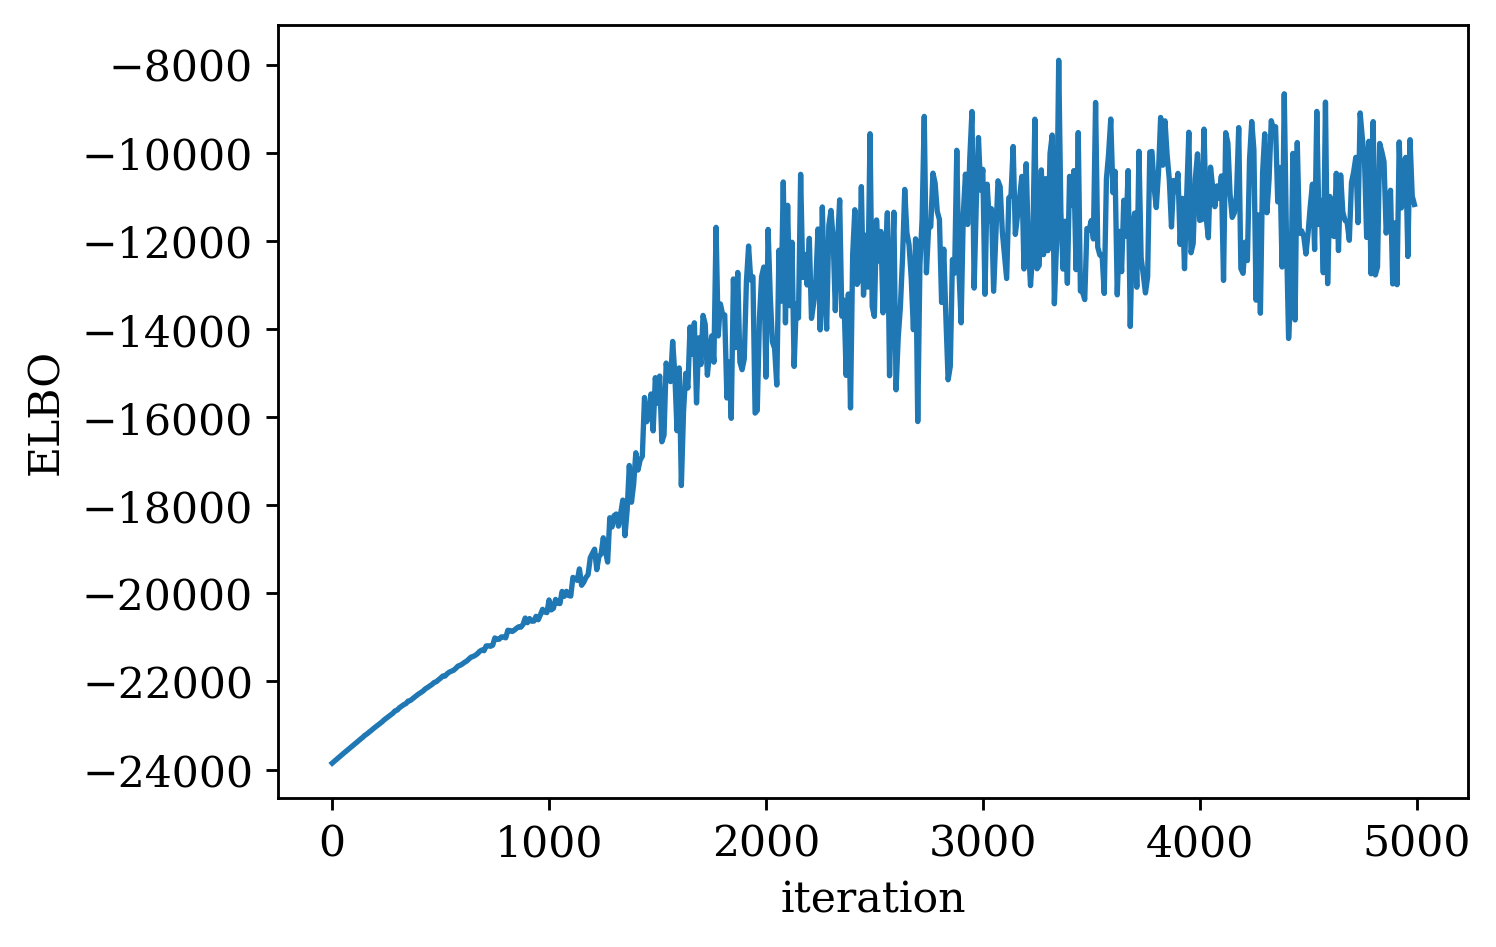

In [ ]:
maxiter = ci_niter(5000)

logf = run_adam(m, train_dataset, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

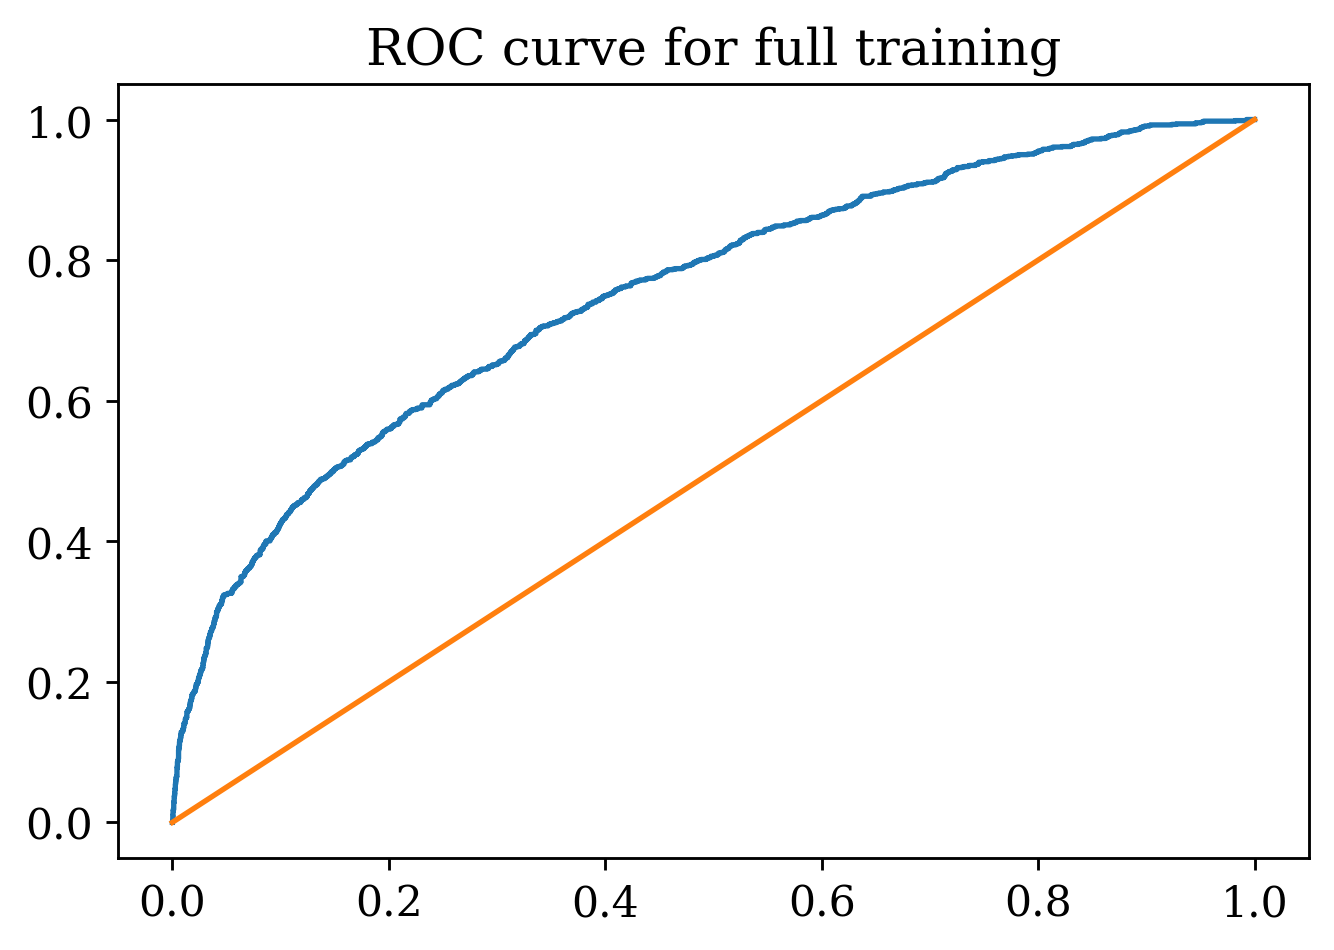

0.751575432913834


In [ ]:
y_pred, _ = m.predict_y(X_test)
roc_auc_full = metrics.roc_auc_score(y_test, y_pred)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred, pos_label=1)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
plt.title('ROC curve for full training')
plt.show()
print(roc_auc_full)

## Сравнение с другими классификаторами

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", # "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    # GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
best_auc = 0
for name, clf in tqdm(zip(names, classifiers)):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f"{name} : {auc : .3f}")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Nearest Neighbors :  0.670
Linear SVM :  0.682
RBF SVM :  0.639
Decision Tree :  0.680
Random Forest :  0.751


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Neural Net :  0.700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost :  0.685
Naive Bayes :  0.722
QDA :  0.582



/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Активное обучение
1. Обучаемся с нуля с использованием неопределенности.
2. Обучаемся с нуля, используя рандомный выбор точек.

In [ ]:

def compute_entropy(x):
    return -(x * tf.math.log(x) + (1-x)*tf.math.log(1-x))

def uncertainty_metric(x, model = None, num_samples = 200, num_bases=1024,  mode = 'entropy'):
    X_num = x.shape[0]
    if mode == 'entropy':
        assert model is not None, 'for entropy mode model is required'

        with model.temporary_paths(num_samples=num_samples, num_bases=num_bases) as temp_paths:
            f = model.predict_f_samples(x)
        entropies = tf.map_fn(fn = compute_entropy, elems = model.likelihood.invlink(f))
        expect_entropies = tf.reduce_mean(entropies, axis=0)
        return expect_entropies

    elif mode == 'BALD':
        assert model is not None, 'for BALD mode model is required'

        expect_entropies = uncertainty_metric(x, model, num_samples, num_bases,  mode='entropy')
        with model.temporary_paths(num_samples=num_samples, num_bases=num_bases) as temp_paths:
            f = model.predict_f_samples(x)
        f = tf.reduce_mean(f, axis=0)
        entropies_expect = compute_entropy(model.likelihood.invlink(f))
        return abs(entropies_expect - expect_entropies)

    else:
        raise NotImplementedError    

In [ ]:
del train_dataset
del kernel
del likelihood
del Z
del maxiter

In [ ]:
# на всякий случай дублирую данные, чтобы точно все было разное.
X_train_active = tf.identity(X_train)
y_train_active = tf.identity(y_train)

X_train_random = tf.identity(X_train)
y_train_random = tf.identity(y_train)

In [ ]:
# sorted_X_train = tf.sort(X_train, axis=0)
# sorted_y_train = tf.reshape(tf.gather(y_train, tf.argsort(X_train, axis=0)), [-1,1])

indices =  tf.argsort(tf.map_fn(tf.norm, X_train), axis=0)
sorted_X_train = tf.gather(X_train, indices)
sorted_y_train = tf.gather(y_train,indices)

In [ ]:
#@title smart active learning
def smart_active_learning():
    active_results = []
    points_X = []
    points_y = []
    uncertainty_values = []
    Z = tf.identity(X_train_active)[::100]
    kernel = gpflow.kernels.SquaredExponential(lengthscales=0.1)
    likelihood = gpflow.likelihoods.Bernoulli()
    model_active = PathwiseSVGP(
        likelihood=likelihood, kernel=kernel, inducing_variable=Z, num_data = len(X_train)
    )

    X_active = X_train_active[::num_initial]
    y_active = y_train_active[::num_initial]

    X_candidates_array = tf.split(tf.identity(sorted_X_train), num_take // num_divide)
    y_values_array = tf.split(tf.identity(sorted_y_train), num_take // num_divide)

    for l in tqdm(range(active_learning_steps)):
        maxiter = ci_niter(num_iterations)
        train_dataset = tf.data.Dataset.from_tensor_slices((X_active, y_active)).repeat().shuffle(len(X_active))
        logf = run_adam(model_active, train_dataset, maxiter)
        
        # indices_candidates = np.random.choice(np.arange(24000), 1000)
        # X_candidates = tf.gather(X_train, indices_candidates)
        

        for (X_candidates, y_values) in zip(X_candidates_array, y_values_array):
            statistics = tf.squeeze(uncertainty_metric(X_candidates, model_active, mode='BALD'))
            values, indices = tf.math.top_k((statistics), k=num_divide)
            new_X = tf.gather(X_candidates,indices)
            new_y = tf.gather(y_values,indices)

            X_active = tf.concat((X_active, new_X), axis=0)
            y_active = tf.concat((y_active, new_y), axis=0)

        # new_y_active = tf.gather(y_train, tf.gather(indices_candidates, indices))
        # new_y_active = tf.gather(tf.identity(y_train),indices)

        points_X.append([X_active[-num_take:]])
        points_y.append([y_active[-num_take:]])

        y_pred, _ = model_active.predict_y(X_test)
        roc_auc = metrics.roc_auc_score(y_test, y_pred)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred, pos_label=1)
        active_results.append(roc_auc)
        # X_active = tf.concat((X_active, new_X_active), axis=0)
        # y_active = tf.concat((y_active, new_y_active), axis=0)
        # X_active = new_X_active
        # y_active = new_y_active
    return model_active, active_results, points_X, points_y, uncertainty_values

In [ ]:
# del train_dataset
# del kernel
# del likelihood
# del Z
# del maxiter
# del X_active
# del y_active

In [ ]:
def random_active_learning():
    random_results = []
    Z = tf.identity(X_train_random)[::100]
    other_kernel = gpflow.kernels.SquaredExponential(lengthscales=0.1)
    likelihood = gpflow.likelihoods.Bernoulli()
    model_random = PathwiseSVGP(
        likelihood=likelihood, kernel=other_kernel, inducing_variable=Z, num_data = len(X_train)
    )

    X_active = X_train_random[::num_initial]
    y_active = y_train_random[::num_initial]

    for l in tqdm(range(active_learning_steps)):
        maxiter = ci_niter(num_iterations)
        train_dataset = tf.data.Dataset.from_tensor_slices((X_active, y_active)).repeat().shuffle(len(X_active))
        logf = run_adam(model_random, train_dataset, maxiter)
        
        indices_candidates = np.random.choice(np.arange(1024), num_take)
        
        # # statistics = tf.squeeze(uncertainty_metric(X_candidates, model_active, mode='BALD'))
        # # _, indices = tf.math.top_k((statistics), k=200)
        new_X_active = tf.gather(tf.identity(X_train), indices_candidates)
        new_y_active = tf.gather(tf.identity(y_train), indices_candidates)

        # X_candidates = X_train


        # statistics = tf.squeeze(uncertainty_metric(X_candidates, model_active, mode='BALD'))
        # _, indices = tf.math.top_k((statistics), k=num_take)
        # new_X_active = tf.gather(X_candidates,indices)
        # new_y_active = tf.gather(y_train, tf.gather(indices_candidates, indices))
        # new_y_active = tf.gather(y_train,indices)


        y_pred, _ = model_random.predict_y(X_test)
        roc_auc = metrics.roc_auc_score(y_test, y_pred)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred, pos_label=1)
        random_results.append(roc_auc)
        X_active = tf.concat((X_active, new_X_active), axis=0)
        y_active = tf.concat((y_active, new_y_active), axis=0)
        # X_active = new_X_active
        # y_active = new_y_active
    return model_random, random_results

In [ ]:
# (64, 100, 100, 200)
active_learning_steps = 32
num_iterations = 500
num_initial = 100
num_take = 400
num_divide = 20
minibatch_size = 100

model_random, random_results = random_active_learning()
gc.collect()
model_active, active_results, points_X, points_y, uncertainty_values = smart_active_learning()
gc.collect()

25769

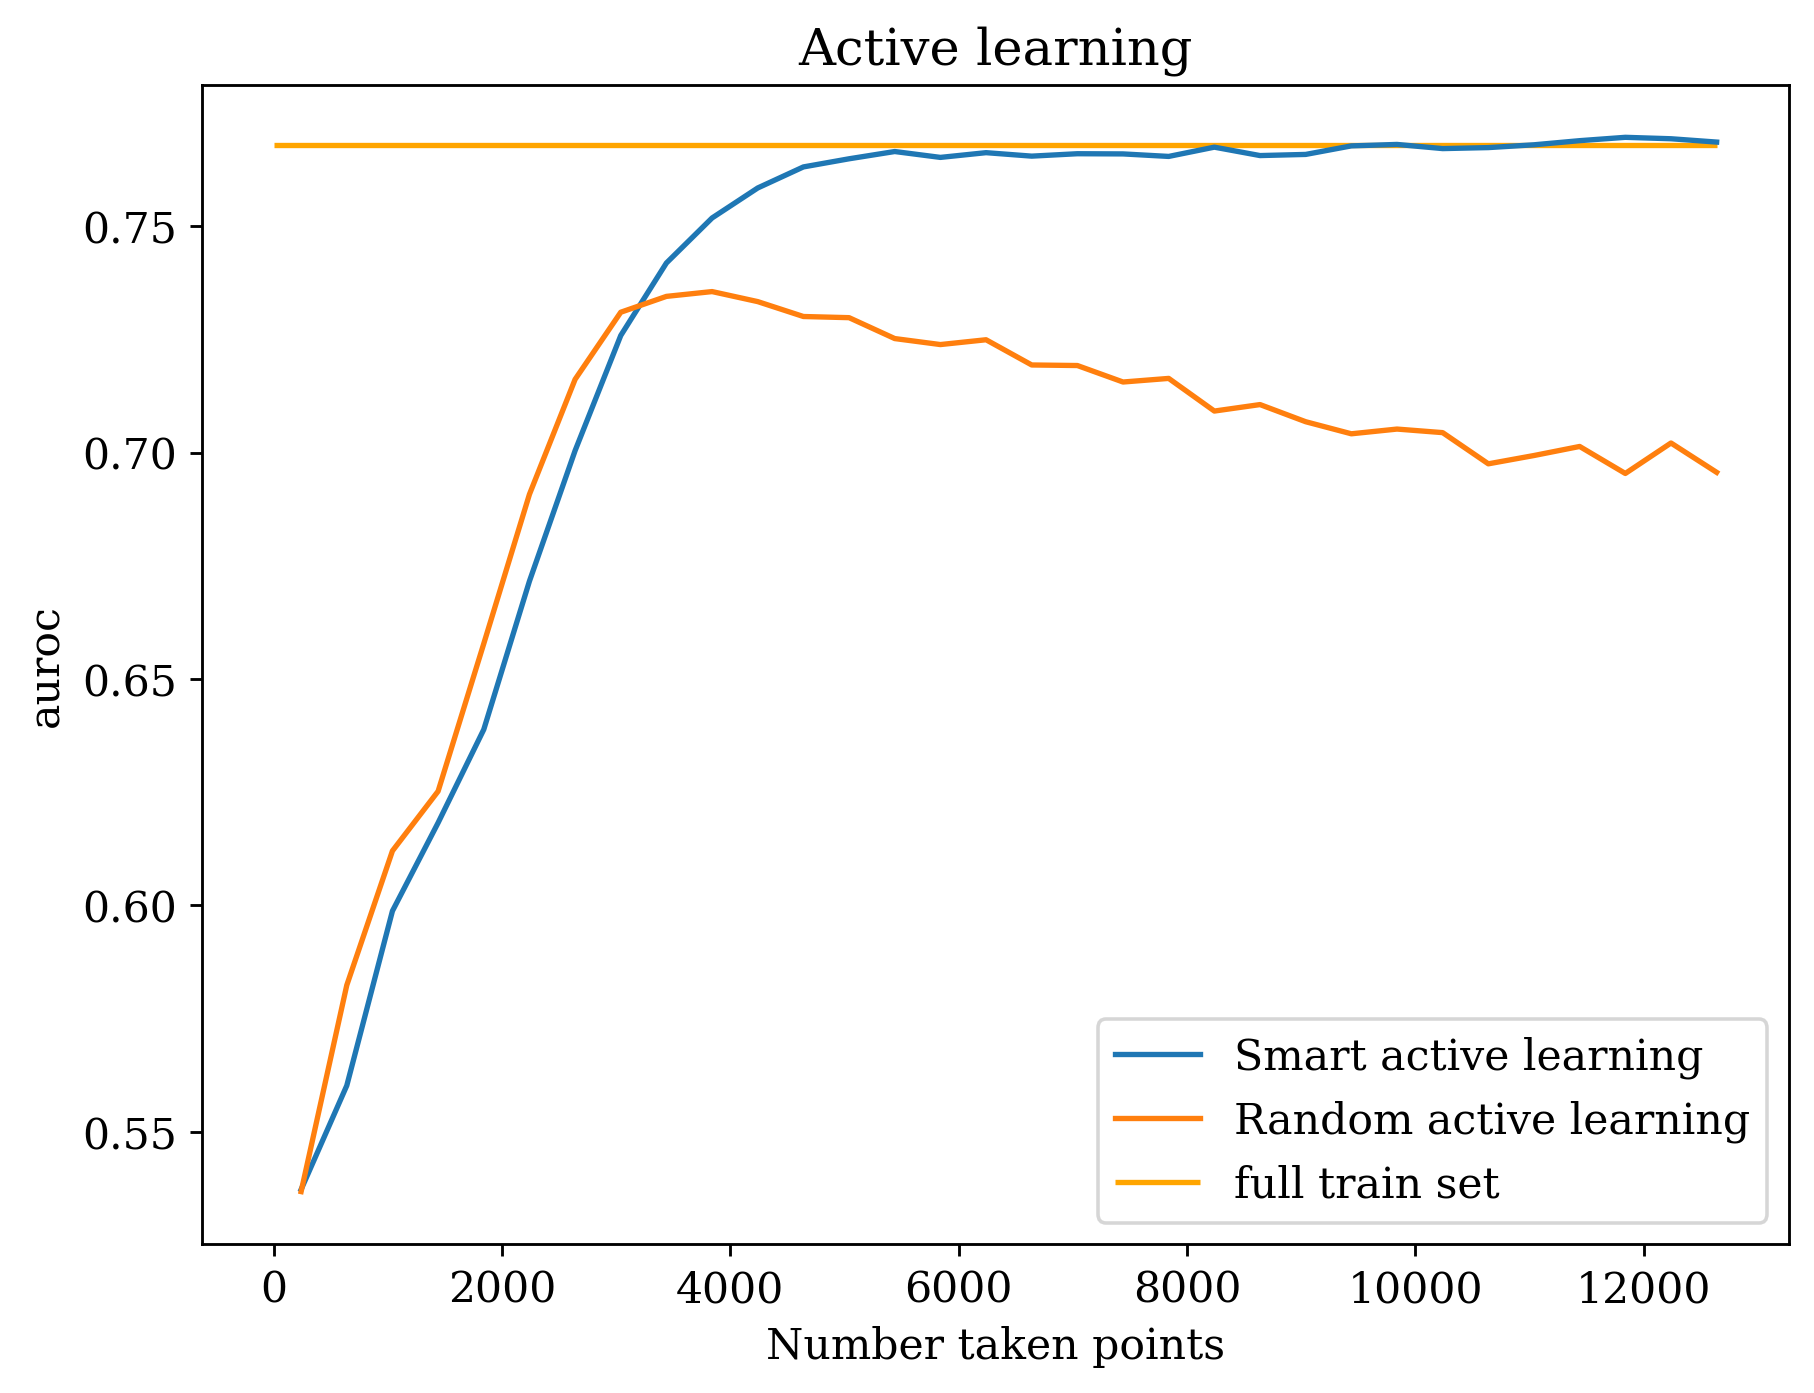

In [ ]:
plt.figure(figsize = (8,6))
size = len(X_train)
plt.plot(np.arange(0,len(active_results),1) * num_take + size / num_initial, active_results, label='Smart active learning')
plt.plot(np.arange(0,len(active_results),1) * num_take + size / num_initial, random_results, label='Random active learning')
# plt.plot([64, 15 * 16 + 64], [0.81, 0.81], label = 'Learning on all train set')
# plt.plot(results)
plt.hlines(roc_auc_full, xmin=0, xmax = (len(active_results)-1) * num_take + size / num_initial, color='orange', label='full train set')
plt.title("Active learning")
plt.xlabel("Number taken points")
plt.ylabel("auroc")
plt.legend(loc='lower right')
plt.show()

In [ ]:
try_model = gpflow.models.SVGP(kernel = model_active.kernel, likelihood=model_active.likelihood, inducing_variable=model_active.inducing_variable)
params = gpflow.utilities.parameter_dict(model_active)
gpflow.utilities.multiple_assign(try_model, params)
with open('active_model.txt', 'w') as f:
    params = gpflow.utilities.parameter_dict(model_active)
    print(params, file=f)
with open('random_model.txt', 'w') as f:
    params = gpflow.utilities.parameter_dict(model_random)
    print(params, file=f)
with open('full_model.txt', 'w') as f:
    params = gpflow.utilities.parameter_dict(m)
    print(params, file=f)

In [ ]:
try_model = gpflow.models.SVGP(kernel = m.kernel, likelihood=m.likelihood, inducing_variable=m.inducing_variable)
params = gpflow.utilities.parameter_dict(m)
gpflow.utilities.multiple_assign(try_model, params)

In [ ]:
params.keys()

dict_keys(['.kernel.variance', '.kernel.lengthscales', '.inducing_variable.Z', '.q_mu', '.q_sqrt'])

In [ ]:
from time import time

In [ ]:

def sample_active(num_samples, X):
    with m.temporary_paths(num_samples=num_samples, num_bases=1024) as temp_paths:
        f = m.predict_f_samples(X)


def sample_traditional(num_samples, X):
    f = try_model.predict_f_samples(X, num_samples=num_samples)


num_samples  = 200
efficient_times = []
traditional_times = []
for num_points in (100, 1000, 2000, 5000, 10000, 15000):
    X = X_train[:num_points]
    efficient_time = %timeit -o sample_active(num_samples, X)
    traditional_time = %timeit -o sample_traditional(num_samples, X)
    traditional_times.append(traditional_time.best)
    efficient_times.append(efficient_time.worst)

10 loops, best of 5: 70.3 ms per loop
10 loops, best of 5: 28.6 ms per loop
10 loops, best of 5: 116 ms per loop
10 loops, best of 5: 142 ms per loop
10 loops, best of 5: 166 ms per loop
1 loop, best of 5: 515 ms per loop
1 loop, best of 5: 310 ms per loop
1 loop, best of 5: 4.01 s per loop
1 loop, best of 5: 599 ms per loop
1 loop, best of 5: 22.5 s per loop
1 loop, best of 5: 995 ms per loop
1 loop, best of 5: 1min 3s per loop


Text(0.5, 1.0, 'Time of sampling - number of points dependency')

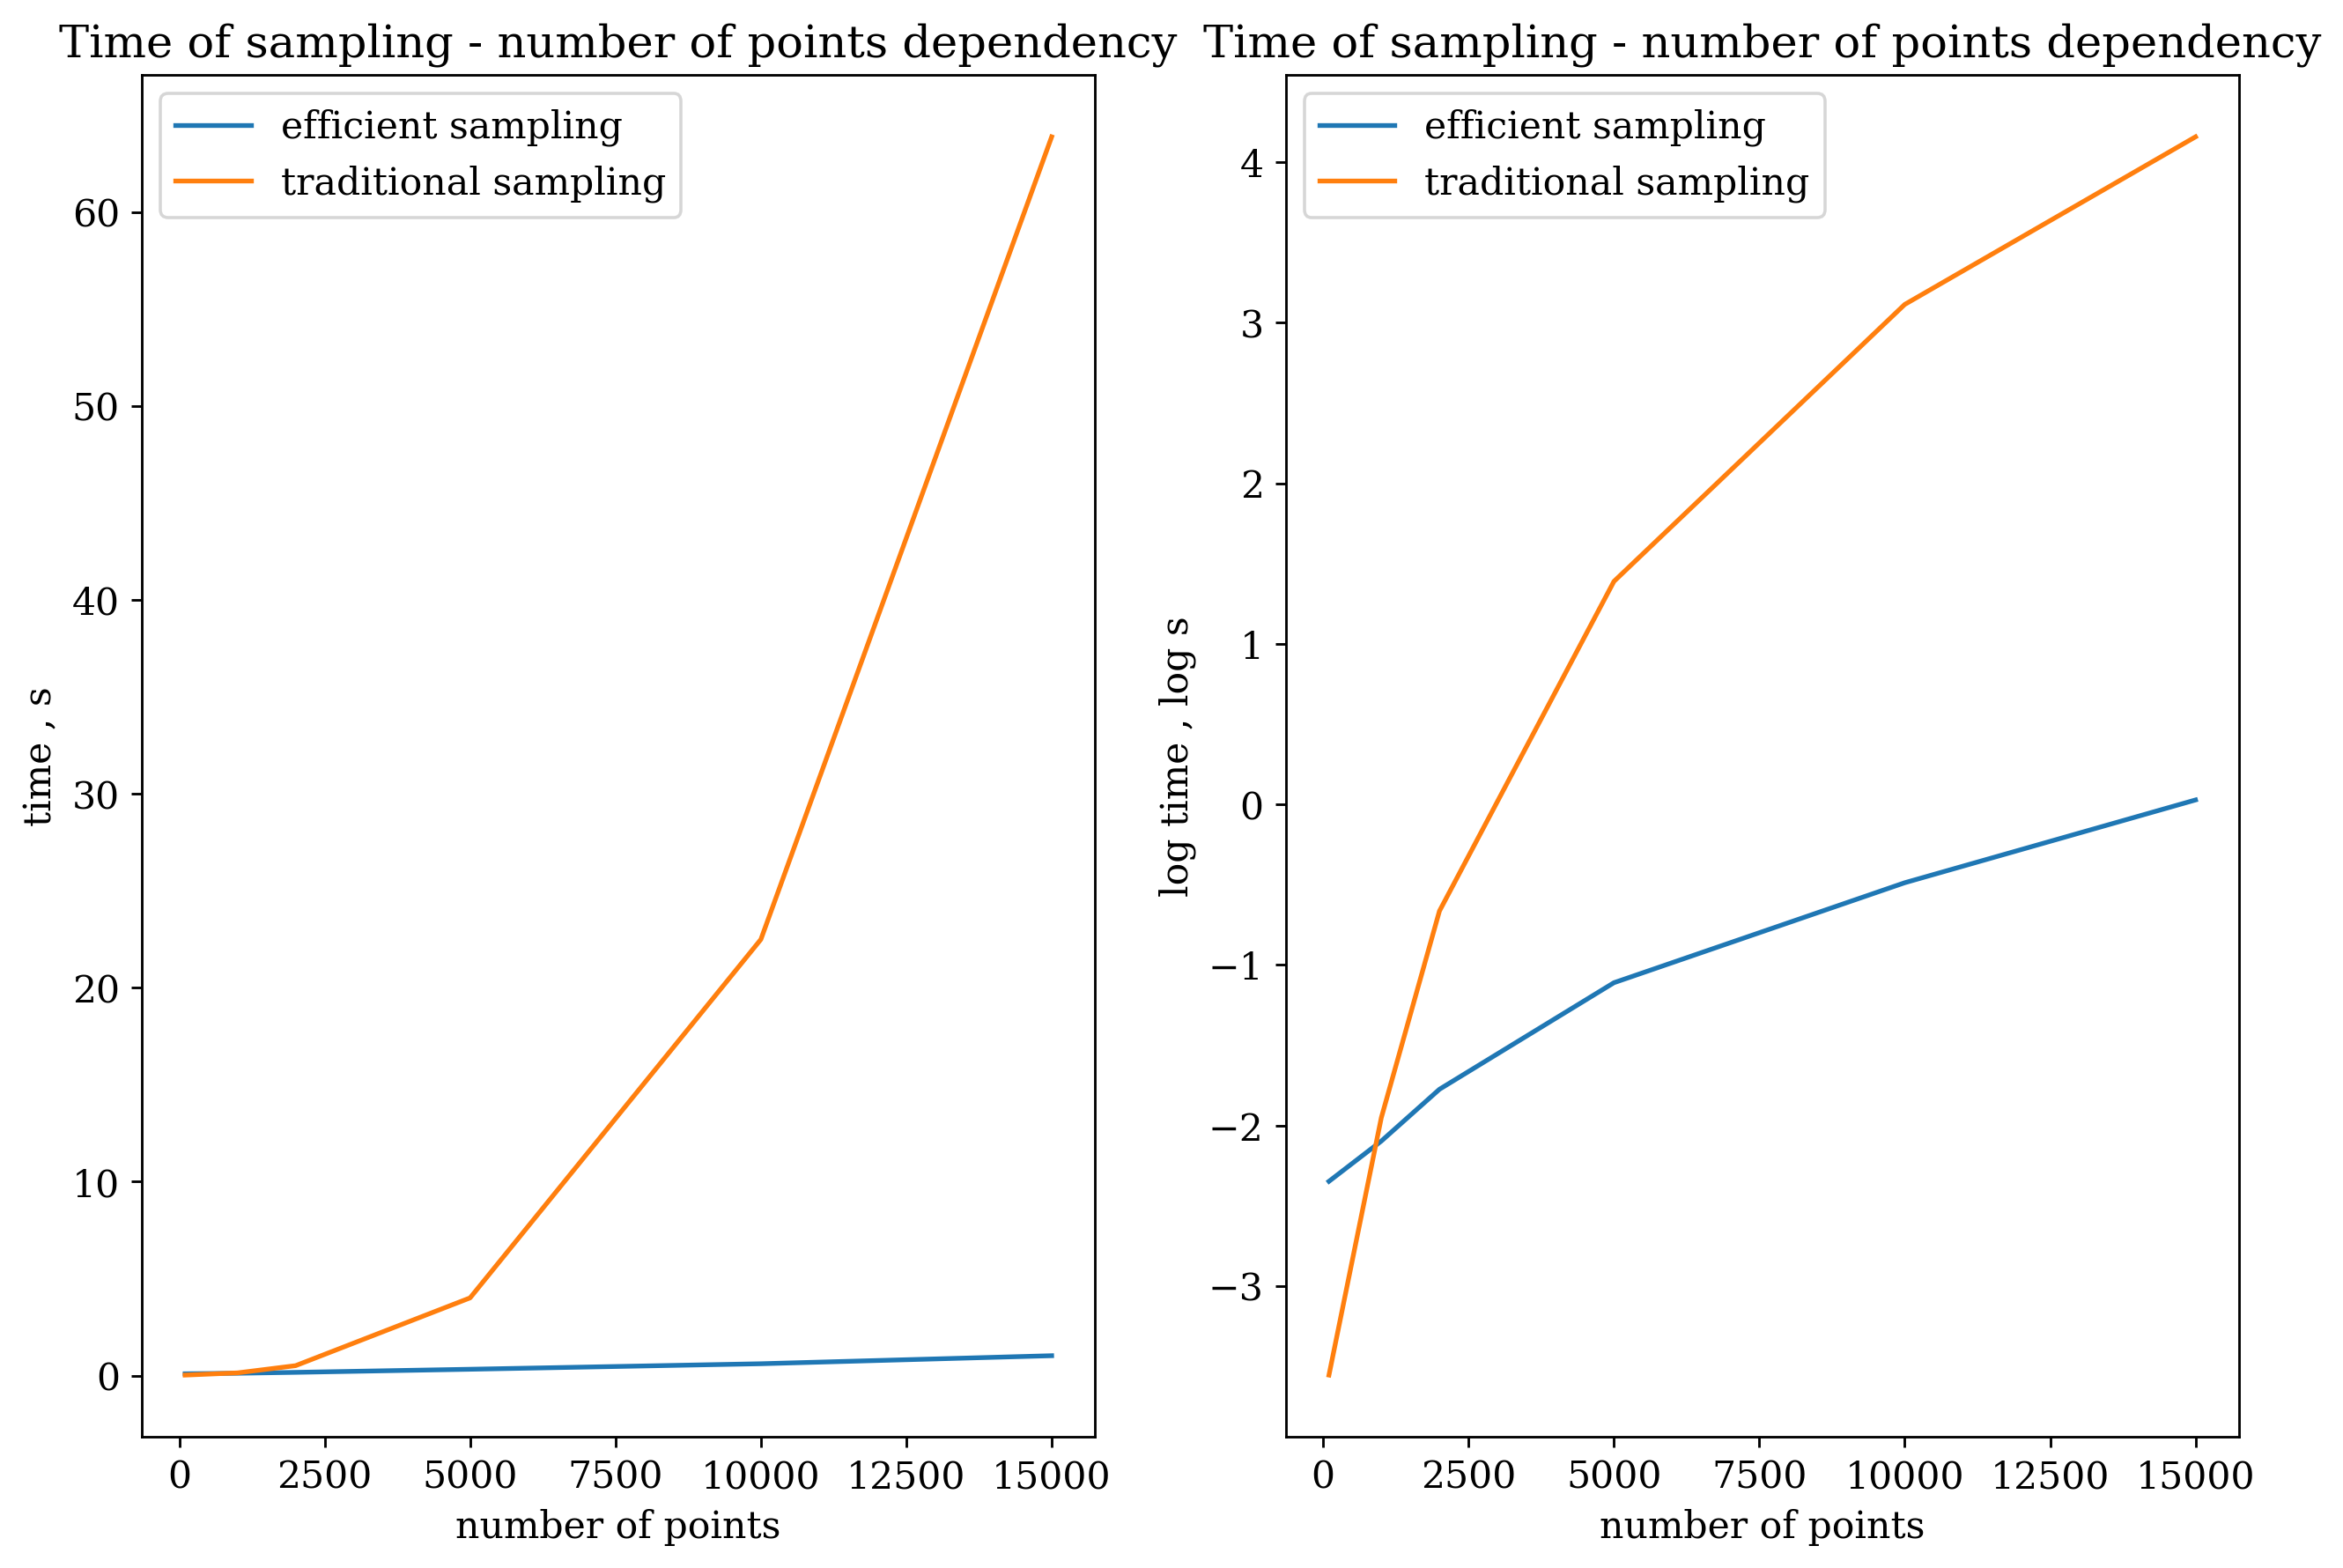

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize = (12, 8))
ax[0].plot((100, 1000, 2000, 5000, 10000, 15000), efficient_times, label = 'efficient sampling')
ax[0].plot((100, 1000, 2000, 5000, 10000, 15000), traditional_times, label = 'traditional sampling')
ax[0].set_ylabel("time , s")
ax[0].set_xlabel("number of points")
ax[0].legend()

ax[1].plot((100, 1000, 2000, 5000, 10000, 15000), np.log(efficient_times), label = 'efficient sampling')
ax[1].plot((100, 1000, 2000, 5000, 10000, 15000), np.log(traditional_times), label = 'traditional sampling')
ax[1].legend()
ax[1].set_ylabel("log time , log s")
ax[1].set_xlabel("number of points")


ax[0].set_title("Time of sampling - number of points dependency")

ax[1].set_title("Time of sampling - number of points dependency")

In [ ]:
num_points  = 3000
efficient_times_samples = []
traditional_times_samples = []
for num_samples in (10, 100, 1000, 2000, 5000, 10000):
    X = X_train[:num_points]
    efficient_time = %timeit -o sample_active(num_samples, X)
    traditional_time = %timeit -o sample_traditional(num_samples, X)
    traditional_times_samples.append(traditional_time.best)
    efficient_times_samples.append(efficient_time.worst)

1 loop, best of 5: 187 ms per loop
1 loop, best of 5: 1.12 s per loop
1 loop, best of 5: 228 ms per loop
1 loop, best of 5: 1.19 s per loop
1 loop, best of 5: 530 ms per loop
1 loop, best of 5: 1.73 s per loop
1 loop, best of 5: 850 ms per loop
1 loop, best of 5: 2.39 s per loop
1 loop, best of 5: 1.88 s per loop
1 loop, best of 5: 4.31 s per loop
1 loop, best of 5: 3.59 s per loop
1 loop, best of 5: 7.56 s per loop


Text(0.5, 1.0, 'Time of sampling - number of samples dependency')

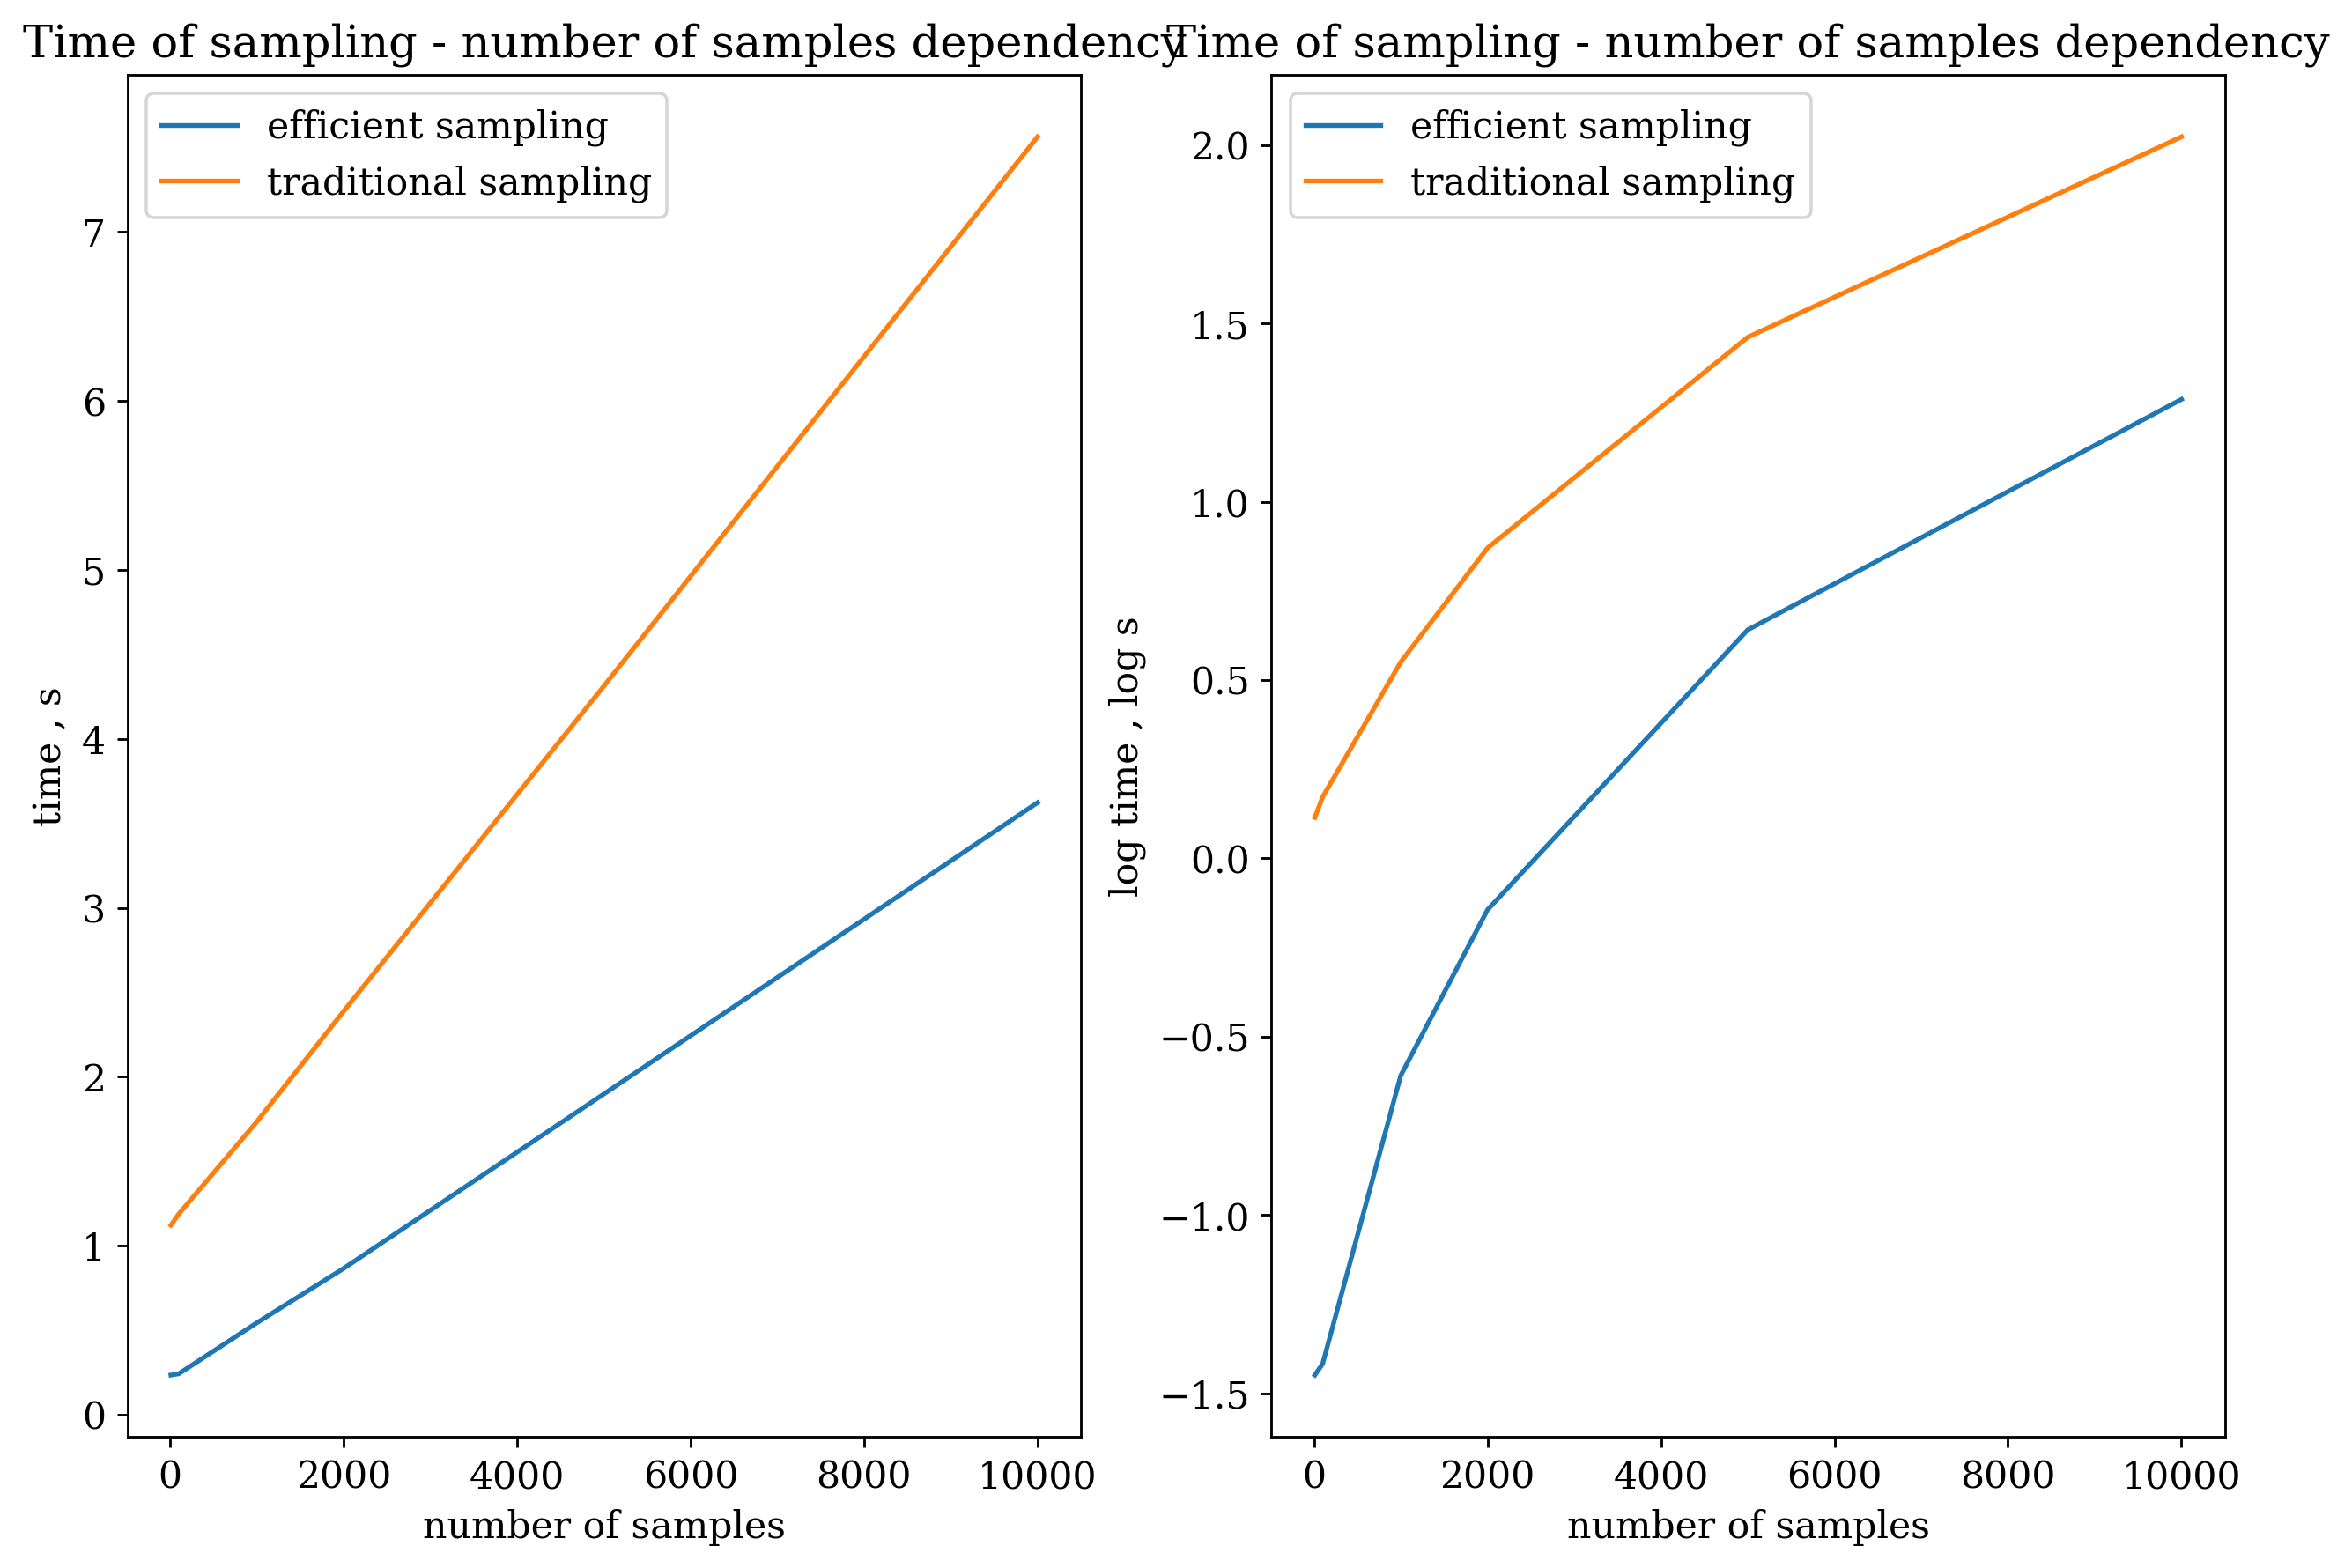

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize = (12, 8))
ax[0].plot((10, 100, 1000, 2000, 5000, 10000), efficient_times_samples, label = 'efficient sampling')
ax[0].plot((10, 100, 1000, 2000, 5000, 10000), traditional_times_samples, label = 'traditional sampling')
ax[0].set_ylabel("time , s")
ax[0].set_xlabel("number of samples")
ax[0].legend()

ax[1].plot((10, 100, 1000, 2000, 5000, 10000), np.log(efficient_times_samples), label = 'efficient sampling')
ax[1].plot((10, 100, 1000, 2000, 5000, 10000), np.log(traditional_times_samples), label = 'traditional sampling')
ax[1].legend()
ax[1].set_ylabel("log time , log s")
ax[1].set_xlabel("number of samples")


ax[0].set_title("Time of sampling - number of samples dependency")

ax[1].set_title("Time of sampling - number of samples dependency")

In [ ]:
for num_samples in 

In [ ]:
best_params

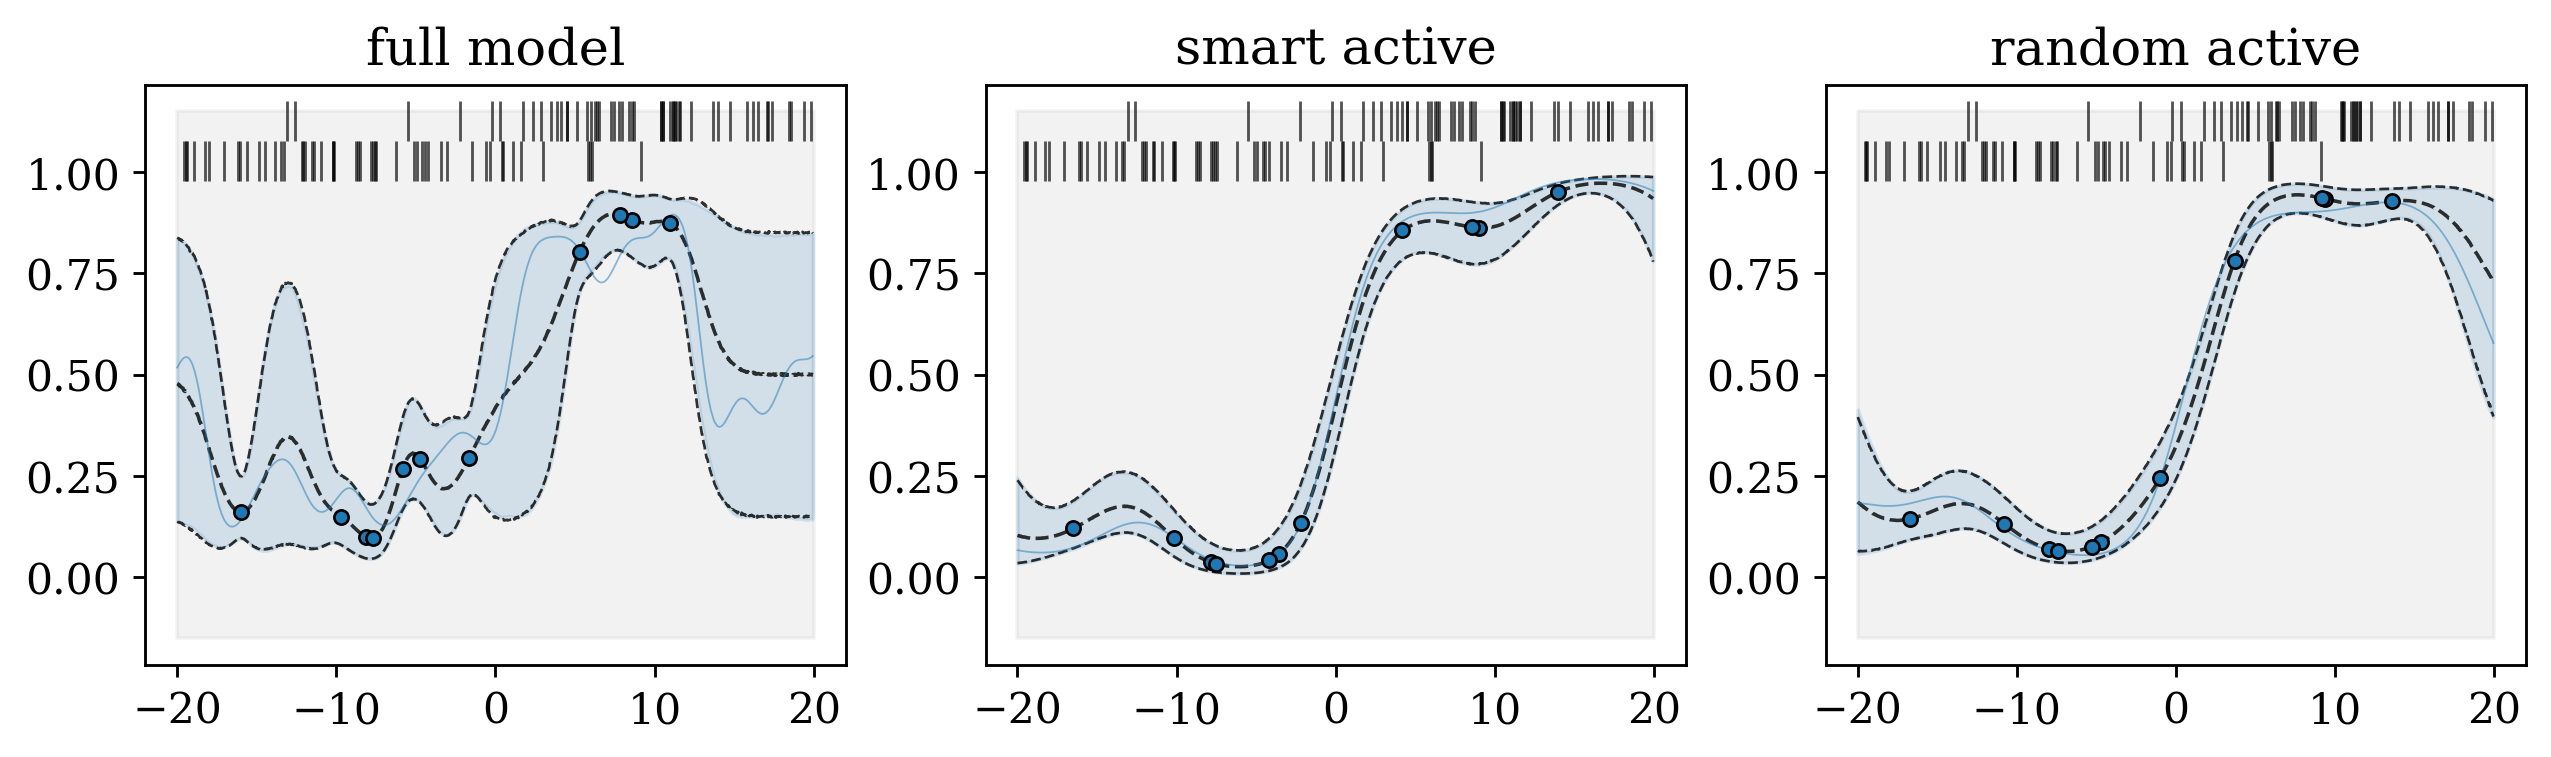

In [ ]:
sorted_X_test= tf.stack(sorted(X_test))
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

lower = tf.cast(0.025, floatx())
upper = tf.cast(0.975, floatx())

# Visualize the training data
label_height = 0.075
ylim = -2 * label_height, 1 + 2 * label_height

hits_positive = tf.where(tf.squeeze(y_train == 1))[::10, 0]
_X_positive = np.squeeze(tf.gather(X_train, hits_positive))
_y_positive = np.full([len(_X_positive)], 1 + label_height if 1 else -label_height)

hits_negative = tf.where(tf.squeeze(y_train == 0))[::10, 0]
_X_negative = np.squeeze(tf.gather(X_train, hits_negative))
_y_negative = np.full([len(_X_negative)], 1 + label_height if 1 else -label_height)

for i, (model, name) in enumerate(zip((m, model_active, model_random), ('full model', 'smart active', 'random active'))):
    mu, sigma2 = map(tf.squeeze, model.predict_f(sorted_X_test))
    with model.temporary_paths(num_samples=10000, num_bases=1024) as temp_paths:
        fnew = tf.squeeze(model.predict_f_samples(sorted_X_test))
    pnew = model.likelihood.invlink(fnew)

    _ = ax[i].fill_between([xmin, xmax], *ylim, zorder=0, color='silver', alpha=0.2)

    ax[i].scatter(_X_positive,
            _y_positive,
            marker=2 ,
            color='k',
            s=128,
            linewidth=0.8,
            alpha=2/3)
    
    ax[i].scatter(_X_negative,
        _y_negative,
        marker=3 ,
        color='k',
        s=128,
        linewidth=0.8,
        alpha=2/3)

    # Estimate ground truth quantiles
    _f = mu + tf.sqrt(sigma2) * tf.random.normal([2 ** 16, len(mu)], dtype=mu.dtype)
    _p = model.likelihood.invlink(_f)
    pl, pm, pu = np.quantile(_p, q=[lower, 0.5, upper], axis=0)
    ax[i].plot(sorted_X_test, pm , '--k', linewidth=1.0, alpha=0.8)
    ax[i].plot(sorted_X_test, pl, '--k', linewidth=0.75, alpha=0.8)
    ax[i].plot(sorted_X_test, pu, '--k', linewidth=0.75, alpha=0.8)

    # Show empirical quantiles
    ax[i].fill_between(np.squeeze(sorted_X_test), 
                    *np.quantile(pnew, q=(lower, upper), axis=0), 
                    color='tab:blue', 
                    alpha=0.15)

    # Visualize some sample paths
    for probs in pnew[:1]:
        ax[i].plot(np.squeeze(sorted_X_test), probs, alpha=0.5, linewidth=0.5, color='tab:blue')
        
    # Plot inducing locations and means
    Z = model.inducing_variable.variables[0].numpy()
    q_mu = model.q_mu.numpy()
    if model.whiten:
        Luu = tf.linalg.cholesky(model.kernel(Z, full_cov=True))
        q_mu = Luu @ q_mu
    ax[i].scatter(Z, 
            model.likelihood.invlink(q_mu),
            zorder=9999, # place these on top
            s=16, 
            color='tab:blue',
            linewidth=0.75,
            edgecolor='k')
    ax[i].set_title(name)



In [ ]:
# Xnew = tf.linspace(tf.cast(0.0, floatx()), tf.cast(1.0, floatx()), 1024)
from copy import deepcopy
mode = 'active'
if mode == 'random':
    model = deepcopy(model_random)
elif mode == 'active':
    model = deepcopy(model_active)
elif mode == 'full':
    model = deepcopy(m)
else:
    raise NotImplementedError
sorted_X_test= tf.stack(sorted(X_test))
mu, sigma2 = map(tf.squeeze, model.predict_f(sorted_X_test))
with model.temporary_paths(num_samples=10000, num_bases=1024) as temp_paths:
    fnew = tf.squeeze(model.predict_f_samples(sorted_X_test))
pnew = model.likelihood.invlink(fnew)

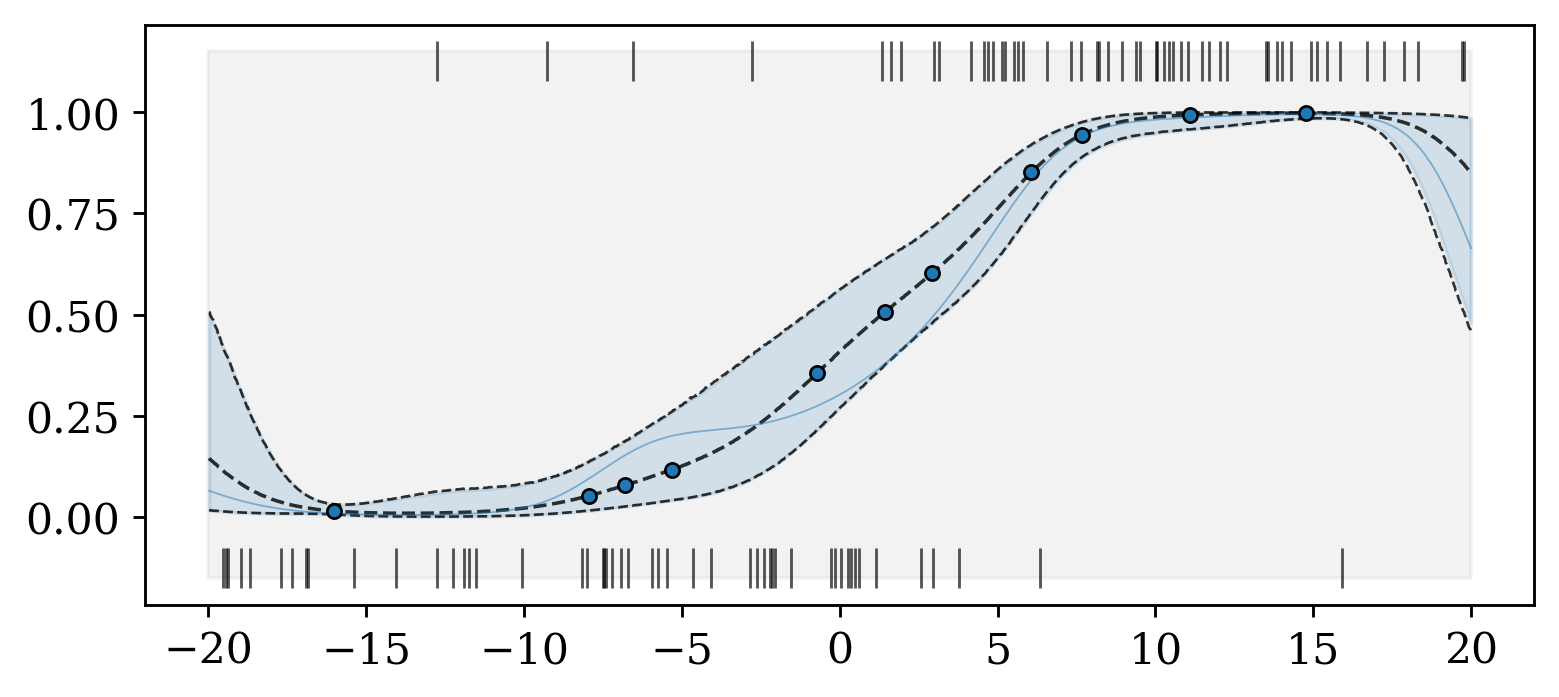

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
lower = tf.cast(0.025, floatx())
upper = tf.cast(0.975, floatx())

# Visualize the training data
label_height = 0.075
ylim = -2 * label_height, 1 + 2 * label_height
_ = ax.fill_between([xmin, xmax], *ylim, zorder=0, color='silver', alpha=0.2)

for class_id in (0, 1):  # show every tenth label
    hits = tf.where(tf.squeeze(y_train == class_id))[::10, 0]
    _X = np.squeeze(tf.gather(X_train, hits))
    _y = np.full([len(_X)], 1 + label_height if class_id else -label_height)
    ax.scatter(_X,
               _y,
               marker=2 if class_id else 3,
               color='k',
               s=128,
               linewidth=0.8,
               alpha=2/3)

# Estimate ground truth quantiles
_f = mu + tf.sqrt(sigma2) * tf.random.normal([2 ** 16, len(mu)], dtype=mu.dtype)
_p = model.likelihood.invlink(_f)
pl, pm, pu = np.quantile(_p, q=[lower, 0.5, upper], axis=0)
ax.plot(sorted_X_test, pm , '--k', linewidth=1.0, alpha=0.8)
ax.plot(sorted_X_test, pl, '--k', linewidth=0.75, alpha=0.8)
ax.plot(sorted_X_test, pu, '--k', linewidth=0.75, alpha=0.8)

# Show empirical quantiles
ax.fill_between(np.squeeze(sorted_X_test), 
                *np.quantile(pnew, q=(lower, upper), axis=0), 
                color='tab:blue', 
                alpha=0.15)

# Visualize some sample paths
for probs in pnew[:1]:
    ax.plot(np.squeeze(sorted_X_test), probs, alpha=0.5, linewidth=0.5, color='tab:blue')
    
# Plot inducing locations and means
Z = model.inducing_variable.variables[0].numpy()
q_mu = model.q_mu.numpy()
if model.whiten:
    Luu = tf.linalg.cholesky(model.kernel(Z, full_cov=True))
    q_mu = Luu @ q_mu
ax.scatter(Z, 
           model.likelihood.invlink(q_mu),
           zorder=9999, # place these on top
           s=16, 
           color='tab:blue',
           linewidth=0.75,
           edgecolor='k')

# # Format axes
# _ = ax.set_xlim(0, 1)
# _ = ax.set_xlabel(r'$\v{x} \in \mathbb{R}$')
# _ = ax.set_ylim(ylim)
# _ = ax.set_ylabel(r'$g^{-1} \circ (f \mid \v{y})$')